In this notebook we will try to classify dog and cat images according to their breeds. We will use the Oxford Pets Kaggle dataset, which consists of 7,349 training images and comprises 37 breeds of cats or dogs, which means that we have an average of 200 training images per cat or dog breed. This is a very low number of images per class, especially because the it's a fine-grained and complex problem (meaning, the images are complex to process, and the different breeds of dogs look very similar, since they are dogs after all), so we should aim to have between 1,000 and 5,000 images per class.

In [ ]:
import imutils
from imutils import paths
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import *
import tensorflow.keras.applications as applications
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import json
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import progressbar
import pickle
import datetime
import h5py
import random

# Downloading data:

First of all, let's download the dataset from kaggle (I will be using google colab because of the free GPU):

In [ ]:
#download the dataset from the competition Dog Breed Identification from kaggle:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c oxford-iiit-pet-dataset
! mkdir input
! unzip oxford-iiit-pet-dataset -d input
! unzip input/train.zip -d input

Next, let's read each path along with its label. In general, image folders follow the structure /train/label/image.jpg, in which case it's easier to extract the labels. In this dataset, the labels are stored in a csv file, so we will extract them in a different way:

In [ ]:
labels = pd.read_csv('/content/input/train.csv')
image_paths = []
breeds = []
for (id, breed) in zip(labels["id"], labels["breed"]):
  image_path = "/content/input/train/{}.jpg".format(id)
  image_paths.append(image_path)
  breeds.append(breed)

# save the number of classes, we'll use this when defining our model
classes = len(set(breeds))

Let's plot a few images along with their labels:

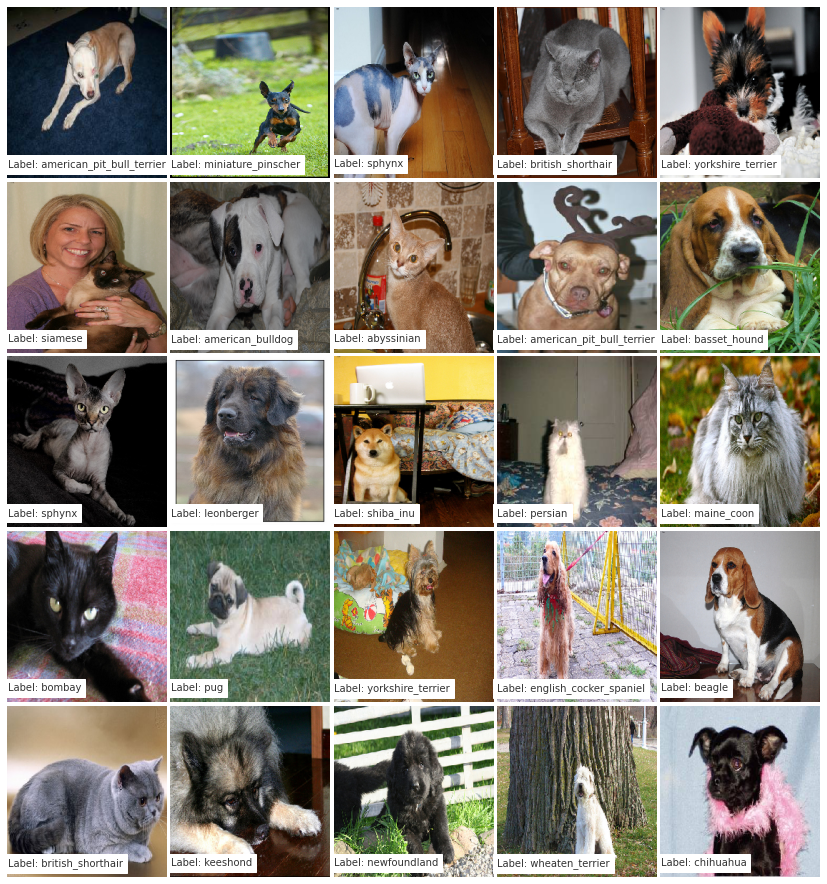

In [ ]:
np.random.seed(42)

fig = plt.figure(1, figsize=(18, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.05)
for i, index in enumerate(np.random.choice(range(len(image_paths)), 25)):
  image = load_img(image_paths[index], target_size=(240,224))
  label = breeds[index]

  ax = grid[i]
  ax.imshow(image)
  ax.text(0, 224, 'Label: {}'.format(label), color='k', backgroundcolor='w', alpha=0.8)
  ax.axis(False)

plt.show()

We can see that some of them have even people in them, so it seems that they're not going to be very easy to classify by a model.

Now that we have our paths and labels stored, let's create training, validation and test sets:

In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, 
                        breeds, test_size=0.2, stratify=breeds, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, 
            train_labels, test_size=0.2, stratify=train_labels, random_state=42)

Let's create a directory for the images, and one directory for each split of the dataset of images:

In [ ]:
os.makedirs('/content/breed')
os.makedirs('/content/breed/train')
os.makedirs('/content/breed/val')
os.makedirs('/content/breed/test')

Inside each directory, let's create one directory per dog breed. We store the images this way so that we can use the .flow_from_directory method.

In [ ]:
for breed in set(breeds):
  os.makedirs('/content/breed/train/{}'.format(breed))
  os.makedirs('/content/breed/val/{}'.format(breed))
  os.makedirs('/content/breed/test/{}'.format(breed))

# Training AlexNet from scratch:

Now that we have our directories created, let's compute the average intensity for each channel across the train split, which we will use to apply mean subtraction, i.e. perform a pixel-wise subtraction of these means from our input images as a form of data normalization (mean
subtraction is used to reduce the effects of lighting variations during classification):

In [ ]:
means = {'B':[], 'G':[], 'R':[]}
for path in train_paths:

  image = cv2.imread(path)
  (B, G, R) = cv2.split(image)
  means['B'].append(np.mean(B))
  means['G'].append(np.mean(G))
  means['R'].append(np.mean(R))

mean_intensities = [np.mean(means['B']), np.mean(means['G']), np.mean(means['R'])]

Now that we have our means stored, we will subtract the mean intensities of the channels to each image, and write it in its correspondent split and breed directory:

In [ ]:
splits = ["train", "val", "test"]
path_splits = [train_paths, val_paths, test_paths]
label_splits = [train_labels, val_labels, test_labels]
for (split, paths, labels) in zip(splits, path_splits, label_splits):  
  counts = {}
  for (i,(path, label)) in enumerate(zip(paths, labels)):

    if label not in counts.keys():
      counts[label] = 0
    else:
      counts[label] += 1
    try:
      image = cv2.imread(path)

      # ensure that these channels are of a floating point data type as OpenCV images are typically represented as unsigned 8-bit integers 
      # (in which case we can’t have negative values, and modulo arithmetic would be performed instead)
      (B, G, R) = cv2.split(image.astype("float32"))

      B = B - mean_intensities[0]
      G = G - mean_intensities[1]
      R = R - mean_intensities[2]
      image = cv2.merge([B, G, R])
      cv2.imwrite('/content/breed/{}/{}/{}.jpg'.format(split, label, counts[label]), image)
    except:
      print("[INFO] Continue...")
      continue

train_path = "/content/breed/train"
val_path = "/content/breed/val"
test_path = "/content/breed/test"

Now that we have our dataset properly stored and means subtracted, let's create our generators. We will use data augmentation and convert the images to a size of (227,227) so we can feed them to our network:

In [ ]:
train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, 
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2)
val_data = ImageDataGenerator()
train_generator = train_data.flow_from_directory(train_path, batch_size=32, target_size=(227,227))
val_generator = val_data.flow_from_directory(val_path, batch_size=32, target_size=(227,227))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size

Now that our data is preprocessed and our generators initialized, let's define the network. We will use the seminal AlexNet architecture (Krizhevsky et al. (2012)). When AlexNet was first introduced there weren't techniques such as batch normalization – in our implementation, we are going to include batch normalization after the activation, as is standard for the majority of image classification tasks using Convolutional Neural Networks. We’ll also include a very small amount of dropout after each pooling operation to further help reduce overfitting, as well as l2 regularization (wheight decay):

In [ ]:
class AlexNet:
  @staticmethod
  def build(width, height, depth, classes, reg=0.0002):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    model = Sequential([
                        # Block #1: first CONV => RELU => POOL layer set
                        Conv2D(96, (11, 11), strides=(4, 4), input_shape=inputShape,
                               padding="same", kernel_regularizer=l2(reg), activation = "relu"),
                        BatchNormalization(axis=chanDim),
                        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                        Dropout(0.25),
                        # Block #2: second CONV => RELU => POOL layer set
                        Conv2D(256, (5, 5), padding="same", kernel_regularizer=l2(reg), 
                               activation = "relu"),
                        BatchNormalization(axis=chanDim),
                        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                        Dropout(0.25),
                        # Block #3: CONV => RELU => CONV => RELU => CONV => RELU
                        Conv2D(384, (3, 3), padding="same", kernel_regularizer=l2(reg), 
                               activation = "relu"),
                        BatchNormalization(axis=chanDim),
                        Conv2D(384, (3, 3), padding="same", kernel_regularizer=l2(reg), 
                               activation = "relu"),
                        BatchNormalization(axis=chanDim),
                        Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(reg), 
                               activation = "relu"),
                        BatchNormalization(axis=chanDim),
                        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                        Dropout(0.25),
                        # Block #4: first set of FC => RELU layers
                        Flatten(),
                        Dense(4096, kernel_regularizer=l2(reg), activation='relu'),
                        BatchNormalization(),
                        Dropout(0.5),
                        # softmax classifier
                        Dense(classes, kernel_regularizer=l2(reg), activation='softmax')
    ])

    return model

Let's instantiate and train our model.

In [ ]:
opt = SGD(0.01)
model = AlexNet.build(width=227, height=227, depth=3, classes=train_generator.num_classes, reg=0.0002)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/alexnet_adam0.001', save_best_only=True)

Let's see a summary of the model:

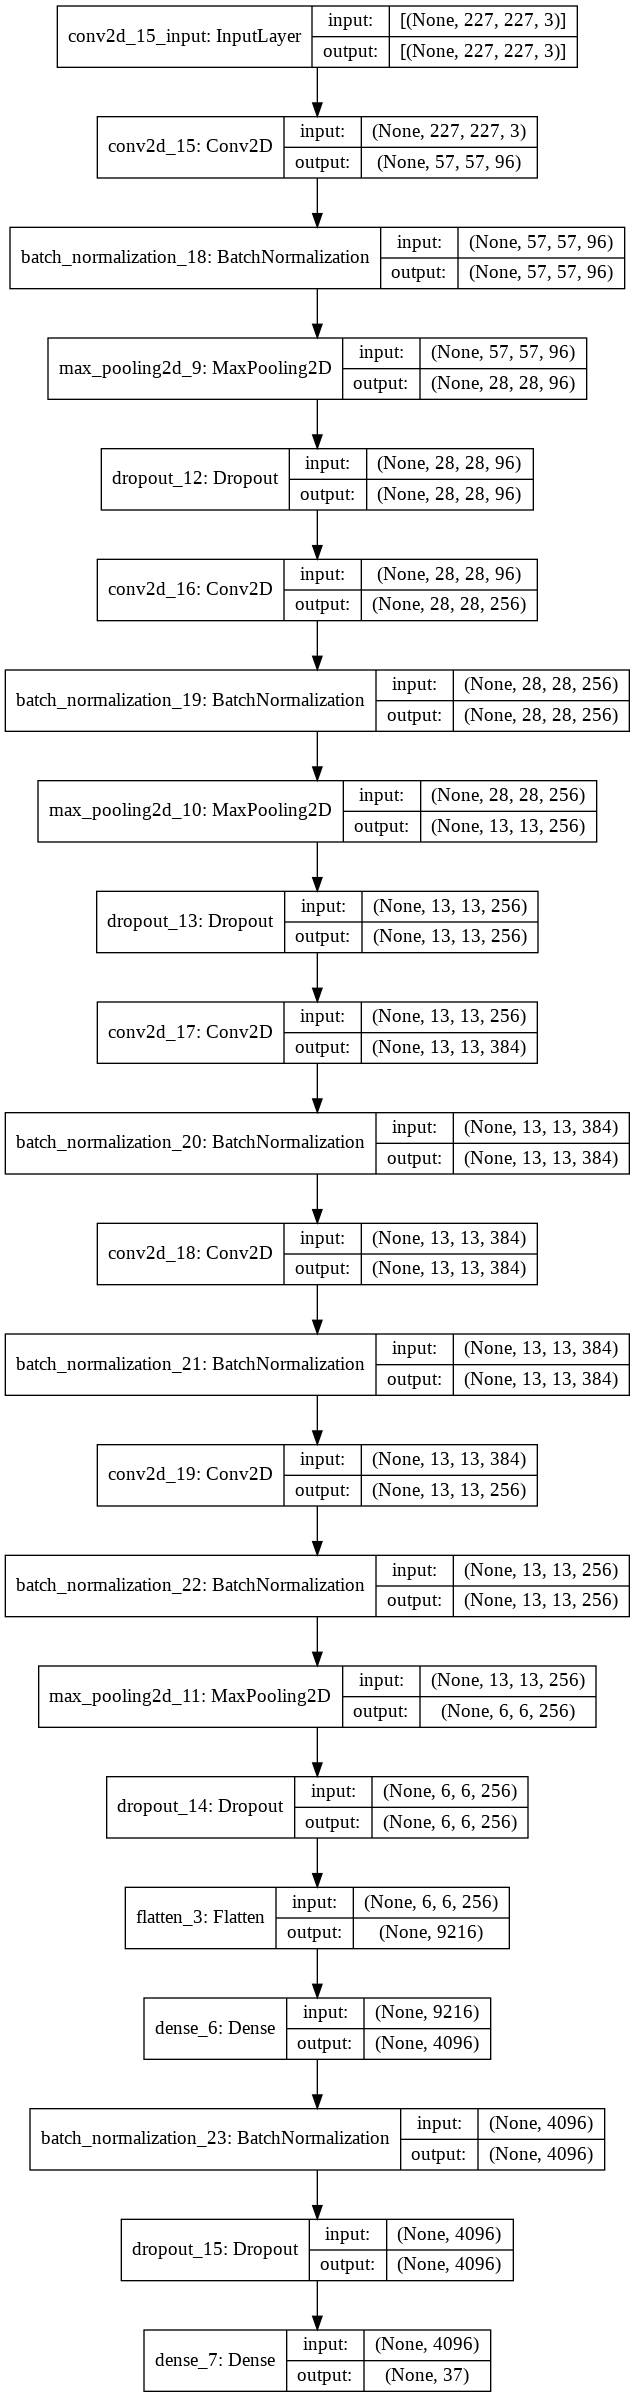

In [ ]:
plot_model(model, show_shapes=True)

Let's train the model:

In [ ]:
H = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=val_generator, validation_steps=val_steps_per_epoch,
          epochs=50, max_queue_size=10, callbacks=[checkpoint], verbose=1)

Highest validation accuracy achieved in 25 epochs: 0.3663194477558136


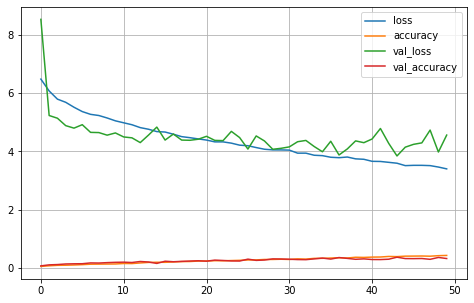

In [ ]:
print("Highest validation accuracy achieved in 25 epochs: {}".format(max(H.history["val_accuracy"])))

pd.DataFrame(H.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

We can see that our model doesn't do very well. This is mainly because the images are complex, the classes are very similar and we have very few data. We start overfitting very clearly since epoch 20. 

# Transfer learning via fine-tuning:

As we have seen, trying to train a network from scratch doesn't yield very good results. This makes a lot of sense, because the images we are working with are very complex, and it's a very fine-grained problem. We tried to train a network from scratch just for the sakes of experimenting, but the most sensible strategy would have been to try to apply transfer learning right from the beggining. In this section we will apply fine tuning to a few networks and compare our results with the ones we got in the previous section.


First of all, let's save the images on disk, because they don't fit in memory. We won't apply any preprocessing yet because each network has its own preprocessing function.

In [ ]:
splits = ["train", "val", "test"]
path_splits = [train_paths, val_paths, test_paths]
label_splits = [train_labels, val_labels, test_labels]
for (split, paths, labels) in zip(splits, path_splits, label_splits):  
  counts = {}
  for (i,(path, label)) in enumerate(zip(paths, labels)):

    if label not in counts.keys():
      counts[label] = 0
    else:
      counts[label] += 1
    try:
      # save each image 
      image = cv2.imread(path)
      cv2.imwrite('/content/breed/{}/{}/{}.jpg'.format(split, label, counts[label]), image)
    except:
      print("[INFO] Continue...")
      continue

train_path = "/content/breed/train"
val_path = "/content/breed/val"
test_path = "/content/breed/test"

## Training networks

Now we will fine-tune a few of networks to see if they work well in this dataset:

### ResNet50

First of all, let's download it:

In [ ]:
resnet50 = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


We will use data augmentation in order to avoid overfitting, and since our images don't fit in memory we'll be using the flow_from_directory method. Since each network has its own preprocessing function (in this case it's applications.resnet.preprocess_input) we will need to create new generetors for each model:

In [ ]:
resnet50_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=applications.resnet.preprocess_input)
resnet50_val_data = ImageDataGenerator(preprocessing_function=applications.resnet.preprocess_input)

resnet50_train_generator = resnet50_train_data.flow_from_directory(train_path, batch_size=32, target_size=(224,224))
resnet50_val_generator = resnet50_val_data.flow_from_directory(val_path, batch_size=32, target_size=(224,224))

train_steps_per_epoch = resnet50_train_generator.n // resnet50_train_generator.batch_size
val_steps_per_epoch = resnet50_val_generator.n // resnet50_val_generator.batch_size

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


Now let's drop the head of the model and replace it with another dense layer:

In [ ]:
# get the network without the final dense layer
headless_resnet50 = Model(inputs=[resnet50.input], outputs=[resnet50.get_layer('avg_pool').output])

# place a new head on top with the desired units, use batch normalization
# for speeding the training and dropout for regularization
model2 = Sequential([
                     headless_resnet50,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_104 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 37)                75813     
Total params: 23,671,717
Trainable params: 79,909
Non-trainable params: 23,591,808
_________________________________________________________________


Let's freeze the base of the network - all the layers other than the head, so that we don't destroy the weights learned in the imagenet dataset.

In [ ]:
model2.get_layer('model_7').trainable = False
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_104 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 37)                75813     
Total params: 23,671,717
Trainable params: 79,909
Non-trainable params: 23,591,808
_________________________________________________________________


Let's define our learning rate schedule. We will use a linear decay learning rate scheduler, so that:



```
alpha = alpha_0 * (1 - current_epoch / max_epochs)
```

Where alpha is the learning rate and alpha_0 is the initial learning rate. In this case, we'll set alpha_0 to 0.01:



In [ ]:
# return a schedule that defines a linear decay learning rate
def schedule(num_epochs):

  def schedule_function(epoch):

    return 0.01*(1 - epoch/num_epochs)

  return schedule_function

# return the callback with such schedule
def scheduler(num_epochs):
  
  return LearningRateScheduler(schedule(num_epochs))

Now, let's compile and fit our model:

In [ ]:
opt = SGD(0.01)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/ResNet50_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H2 = model2.fit(resnet50_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=resnet50_val_generator, validation_steps=val_steps_per_epoch,
          epochs=20, max_queue_size=10, callbacks=[resnet50_checkpoint, scheduler(20)], verbose=1)

I will reload the model that performed best on the validation data as a way of early stopping:

In [ ]:
model2 = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50_regularized_finetuned')

model2.evaluate(resnet50_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 6s 154ms/step - loss: 0.3889 - accuracy: 0.8889


[0.388897180557251, 0.8888888955116272]

We get a very respectable validation accuracy, especially taking into account that we have 4703 images belonging to 37 classes of dog and cat breeds - a fine-grained problem. I interrupted the training when the validation loss and accuracy had stagnated, but the training loss and accuracy kept improving for a few epochs.

**We'll do exactly the same for a few pretrained networks:**

### ResNet50V2

In [ ]:
resnet50v2 = ResNet50V2(weights='imagenet')

102875136/102869336 [==============================] - 2s 0us/step


In [ ]:
resnet50v2_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2, 
                  preprocessing_function=applications.resnet_v2.preprocess_input)
resnet50v2_val_data = ImageDataGenerator(preprocessing_function=applications.resnet_v2.preprocess_input)

resnet50v2_train_generator = resnet50v2_train_data.flow_from_directory(train_path, batch_size=32, target_size=(224,224))
resnet50v2_val_generator = resnet50v2_val_data.flow_from_directory(val_path, batch_size=32, target_size=(224,224))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
headless_resnet50v2 = Model(inputs=[resnet50v2.input], outputs=[resnet50v2.get_layer('avg_pool').output])

model3 = Sequential([
                     headless_resnet50v2,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 2048)              23564800  
_________________________________________________________________
batch_normalization_103 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                75813     
Total params: 23,648,805
Trainable params: 79,909
Non-trainable params: 23,568,896
_________________________________________________________________


In [ ]:
model3.get_layer('model_6').trainable = False
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 2048)              23564800  
_________________________________________________________________
batch_normalization_103 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                75813     
Total params: 23,648,805
Trainable params: 79,909
Non-trainable params: 23,568,896
_________________________________________________________________


In [ ]:
opt = SGD(0.001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
resnet50v2_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H3 = model3.fit(resnet50v2_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=resnet50v2_val_generator, validation_steps=val_steps_per_epoch,
          epochs=15, max_queue_size=10, callbacks=[resnet50v2_checkpoint, scheduler(15)], verbose=1)

In [ ]:
model3 = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned')

model3.evaluate(resnet50v2_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 7s 157ms/step - loss: 0.3440 - accuracy: 0.8993


[0.34398767352104187, 0.8993055820465088]

### Xception

In [ ]:
xception = Xception(weights='imagenet')

91889664/91884032 [==============================] - 1s 0us/step


In [ ]:
xception_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=applications.xception.preprocess_input)
xception_val_data = ImageDataGenerator(preprocessing_function=applications.xception.preprocess_input)

xception_train_generator = xception_train_data.flow_from_directory(train_path, batch_size=32, target_size=(299,299))
xception_val_generator = xception_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
headless_xception = Model(inputs=[xception.input], outputs=[xception.get_layer('avg_pool').output])

model4 = Sequential([
                     headless_xception,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_305 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                75813     
Total params: 20,945,485
Trainable params: 79,909
Non-trainable params: 20,865,576
_________________________________________________________________


In [ ]:
model4.get_layer('model_4').trainable = False
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_305 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                75813     
Total params: 20,945,485
Trainable params: 79,909
Non-trainable params: 20,865,576
_________________________________________________________________


In [ ]:
opt = SGD(0.01)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
xception_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/Xception_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H4 = model4.fit(xception_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=xception_val_generator, validation_steps=val_steps_per_epoch,
          epochs=20, max_queue_size=10, callbacks=[xception_checkpoint, scheduler(20)], verbose=1)

In [ ]:
model4 = load_model('/content/drive/MyDrive/colab/dog_breed/Xception_regularized_finetuned')

model4.evaluate(xception_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 16s 223ms/step - loss: 0.2657 - accuracy: 0.9245


[0.2657431364059448, 0.9244791865348816]

### Inception

In [ ]:
inception_v3 = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
inception_v3_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=applications.inception_v3.preprocess_input)
inception_v3_val_data = ImageDataGenerator(preprocessing_function=applications.inception_v3.preprocess_input)

inception_v3_train_generator = inception_v3_train_data.flow_from_directory(train_path, batch_size=32, target_size=(299,299))
inception_v3_val_generator = inception_v3_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
headless_inception = Model(inputs=[inception_v3.input], outputs=[inception_v3.get_layer('avg_pool').output])

model5 = Sequential([
                     headless_inception,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              21802784  
_________________________________________________________________
batch_normalization_99 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                75813     
Total params: 21,886,789
Trainable params: 21,848,261
Non-trainable params: 38,528
_________________________________________________________________


In [ ]:
model5.get_layer('model_1').trainable = False
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              21802784  
_________________________________________________________________
batch_normalization_99 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                75813     
Total params: 21,886,789
Trainable params: 79,909
Non-trainable params: 21,806,880
_________________________________________________________________


In [ ]:
opt = SGD(0.01)
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
inception_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/InceptionV3_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H5 = model5.fit(inception_v3_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=inception_v3_val_generator, validation_steps=val_steps_per_epoch,
          epochs=20, max_queue_size=10, callbacks=[inception_checkpoint, scheduler(20)], verbose=1)

In [ ]:
model5 = load_model('/content/drive/MyDrive/colab/dog_breed/InceptionV3_regularized_finetuned')

model5.evaluate(inception_v3_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 8s 182ms/step - loss: 0.2859 - accuracy: 0.9271


[0.2858530282974243, 0.9270833134651184]

### NASNetLarge

In [ ]:
nasnet = NASNetLarge(weights='imagenet')

359751680/359748576 [==============================] - 3s 0us/step


In [ ]:
nasnet_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=applications.nasnet.preprocess_input)
nasnet_val_data = ImageDataGenerator(preprocessing_function=applications.nasnet.preprocess_input)

nasnet_train_generator = nasnet_train_data.flow_from_directory(train_path, batch_size=32, target_size=(331,331))
nasnet_val_generator = nasnet_val_data.flow_from_directory(val_path, batch_size=32, target_size=(331,331))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
headless_nasnet = Model(inputs=[nasnet.input], outputs=[nasnet.get_layer('global_average_pooling2d').output])

model6 = Sequential([
                     headless_nasnet,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model6.summary()

In [ ]:
model6.get_layer('model_4').trainable = False
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 4032)              84916818  
_________________________________________________________________
batch_normalization_101 (Bat (None, 4032)              16128     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4032)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                149221    
Total params: 85,082,167
Trainable params: 157,285
Non-trainable params: 84,924,882
_________________________________________________________________


In [ ]:
opt = SGD(0.01)
model6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
nasnet_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/NASNetLarge_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H6 = model6.fit(nasnet_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=nasnet_val_generator, validation_steps=val_steps_per_epoch,
          epochs=15, max_queue_size=10, callbacks=[nasnet_checkpoint, scheduler], verbose=1)

In [ ]:
model6 = load_model('/content/drive/MyDrive/colab/dog_breed/NASNetLarge_regularized_finetuned')

model6.evaluate(nasnet_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 25s 561ms/step - loss: 0.2525 - accuracy: 0.9366


[0.25254347920417786, 0.9366319179534912]

### InceptionResNetV2

In [ ]:
inceptionresnetv2 = InceptionResNetV2(weights='imagenet')

225214464/225209952 [==============================] - 1s 0us/step


In [ ]:
inceptionresnetv2_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=applications.inception_resnet_v2.preprocess_input)
inceptionresnetv2_val_data = ImageDataGenerator(preprocessing_function=applications.inception_resnet_v2.preprocess_input)

inceptionresnetv2_train_generator = inceptionresnetv2_train_data.flow_from_directory(train_path, batch_size=32, target_size=(299,299))
inceptionresnetv2_val_generator = inceptionresnetv2_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))

Found 4703 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


In [ ]:
headless_inceptionresnetv2 = Model(inputs=[inceptionresnetv2.input], outputs=[inceptionresnetv2.get_layer('avg_pool').output])

model7 = Sequential([
                     headless_inceptionresnetv2,
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(classes, activation='softmax')
])

model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 1536)              54336736  
_________________________________________________________________
batch_normalization_304 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 37)                56869     
Total params: 54,399,749
Trainable params: 54,336,133
Non-trainable params: 63,616
_________________________________________________________________


In [ ]:
model7.get_layer('model_3').trainable = False
model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 1536)              54336736  
_________________________________________________________________
batch_normalization_304 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 37)                56869     
Total params: 54,399,749
Trainable params: 59,941
Non-trainable params: 54,339,808
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(patience=5)

In [ ]:
opt = SGD(0.01)
model7.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
inceptionresnetv2_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/InceptionResNetV2_regularized_finetuned', save_best_only=True, monitor='val_accuracy')

In [ ]:
H7 = model7.fit(inceptionresnetv2_train_generator, steps_per_epoch=train_steps_per_epoch, 
          validation_data=inceptionresnetv2_val_generator, validation_steps=val_steps_per_epoch,
          epochs=20, max_queue_size=10, callbacks=[inceptionresnetv2_checkpoint, scheduler, early_stopping], verbose=1)

In [ ]:
model7 = load_model('/content/drive/MyDrive/colab/dog_breed/InceptionResNetV2_regularized_finetuned')

model7.evaluate(inceptionresnetv2_val_generator, steps=val_steps_per_epoch)

36/36 [==============================] - 14s 296ms/step - loss: 0.1706 - accuracy: 0.9418


[0.17064130306243896, 0.9418402910232544]

# Ensemble:

Now that we have trained all the models individually, let's do an ensemble and test its validation accuracy. First of all, let's reinitialize the generators: 

In [ ]:
resnet50_val_data = ImageDataGenerator(preprocessing_function=applications.resnet.preprocess_input)
resnet50_val_generator = resnet50_val_data.flow_from_directory(val_path, batch_size=32, target_size=(224,224))


resnet50v2_val_data = ImageDataGenerator(preprocessing_function=applications.resnet_v2.preprocess_input)
resnet50v2_val_generator = resnet50v2_val_data.flow_from_directory(val_path, batch_size=32, target_size=(224,224))

xception_val_data = ImageDataGenerator(preprocessing_function=applications.xception.preprocess_input)
xception_val_generator = xception_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))


inception_v3_val_data = ImageDataGenerator(preprocessing_function=applications.inception_v3.preprocess_input)
inception_v3_val_generator = inception_v3_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))

nasnet_val_data = ImageDataGenerator(preprocessing_function=applications.nasnet.preprocess_input)
nasnet_val_generator = nasnet_val_data.flow_from_directory(val_path, batch_size=32, target_size=(331,331))

inceptionresnetv2_val_data = ImageDataGenerator(preprocessing_function=applications.inception_resnet_v2.preprocess_input)
inceptionresnetv2_val_generator = nasnet_val_data.flow_from_directory(val_path, batch_size=32, target_size=(299,299))

Found 1176 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.
Found 1176 images belonging to 37 classes.


Let's load the models that performed the best on the validation data (we assume that they will generalize better than the ones that didn't):

In [ ]:
resnet50 = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50_regularized_finetuned')
resnet50v2 = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned')
xception = load_model('/content/drive/MyDrive/colab/dog_breed/Xception_regularized_finetuned')
inception = load_model('/content/drive/MyDrive/colab/dog_breed/InceptionV3_regularized_finetuned')
inceptionresnetv2 = load_model('/content/drive/MyDrive/colab/dog_breed/InceptionResNetV2_regularized_finetuned')
nasnet = load_model('/content/drive/MyDrive/colab/dog_breed/NASNetLarge_regularized_finetuned')

Because some of our models performed better than others, we'll be doing a weighted average of the predictions, these are the weights we'll use:

In [ ]:
model_weights = {nasnet:4, inceptionresnetv2:2, inception:2, xception:2, resnet50:1, resnet50v2:1}

Since we don't have a function for evaluating ensembles when we pull the images from the directories, we'll create one:

In [ ]:
# convert the label to the way the method flow_from_directory encodes them
def label_decoder(label):
  
  return nasnet_val_generator.class_indices[label]

# given a set of models, sizes of the images for each model, and preprocessing
# functions for each model, a dictionary for the weights of the predictions of each model
# and a set of image paths, return the accuracy of the ensemble
def evaluate_ensemble(models, model_weights, image_paths):
  
  # initialize the total of correct predictions
  total_correct = 0

  # get the paths along the labels
  labeled_paths = []
  for path in image_paths:
    label = path.split(os.path.sep)[-2]
    label = label_decoder(label)
    labeled_paths.append((path, label))

  for path, label in labeled_paths:
    # for each image, initialize the list of predictions of each model
    preds = []

    # for each model, preprocess the image and append the prediction 
    # along with the model
    for (model, target_size, preprocessor) in models:
      image = load_img(path, target_size=target_size)
      image = img_to_array(image)
      image = preprocessor(image)
      image = np.expand_dims(image, axis=0)
      prediction = model.predict(image)
      preds.append((model, prediction))

    # sum the weighted predictions and divide between the total weight
    probabilities = sum([model_weights[model]*prediction for (model, prediction) in preds]) / sum([model_weights[model] for (model, prediction) in preds])
    final_prediction = probabilities.argmax()

    # if correct, sum 1
    if final_prediction == label:
      total_correct += 1

  return total_correct/len(image_paths)

Let's create our list of models and paths:

In [ ]:
models = [(nasnet, (331,331), applications.nasnet.preprocess_input),
          (inceptionresnetv2, (299,299), applications.inception_resnet_v2.preprocess_input),
          (resnet50, (224,224), applications.resnet.preprocess_input),
          (resnet50v2, (224, 224), applications.resnet_v2.preprocess_input),
          (xception, (299, 299), applications.xception.preprocess_input),
          (inception, (299,299), applications.inception_v3.preprocess_input)]
    
val_paths = list(imutils.paths.list_images(val_path))

Finally, let's compute the accuracy over the validation images:

In [ ]:
validation_ensemble_accuracy = evaluate_ensemble(models, model_weights, val_paths)
print("The model ensemble has a validation accuracy of {}".format(validation_ensemble_accuracy))

The model ensemble has a validation accuracy of 0.9455782312925171


Definitely higher than the individual models! Now we have to check that we haven't overfitted the validation set, so let's check the preformance on the test set:

In [ ]:
test_paths = list(imutils.paths.list_images(test_path))

test_ensemble_accuracy = evaluate_ensemble(models, test_paths)

print("The model ensemble has a test accuracy of {}".format(test_ensemble_accuracy))

The model ensemble has a test accuracy of 0.9469387755102041


It seems that we didn't overfit the validation data! In fact, it performed even slightly better on the test data. It would have performed even better if we had retrained all the models in the training and validation data.

Let's see the model predict some test labels:

In [ ]:
def get_ensemble_prediction(path):
  preds = []

  for (model, target_size, preprocessor) in models:
    image = load_img(path, target_size=target_size)
    image = img_to_array(image)
    image = preprocessor(image)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    preds.append((model, prediction))

  # sum the weighted predictions and divide between the total weight
  probabilities = sum([model_weights[model]*prediction for (model, prediction) in preds]) / sum([model_weights[model] for (model, prediction) in preds])
  final_prediction = probabilities.argmax() 
  predicted_label = list(nasnet_val_generator.class_indices.keys())[final_prediction]

  return predicted_label

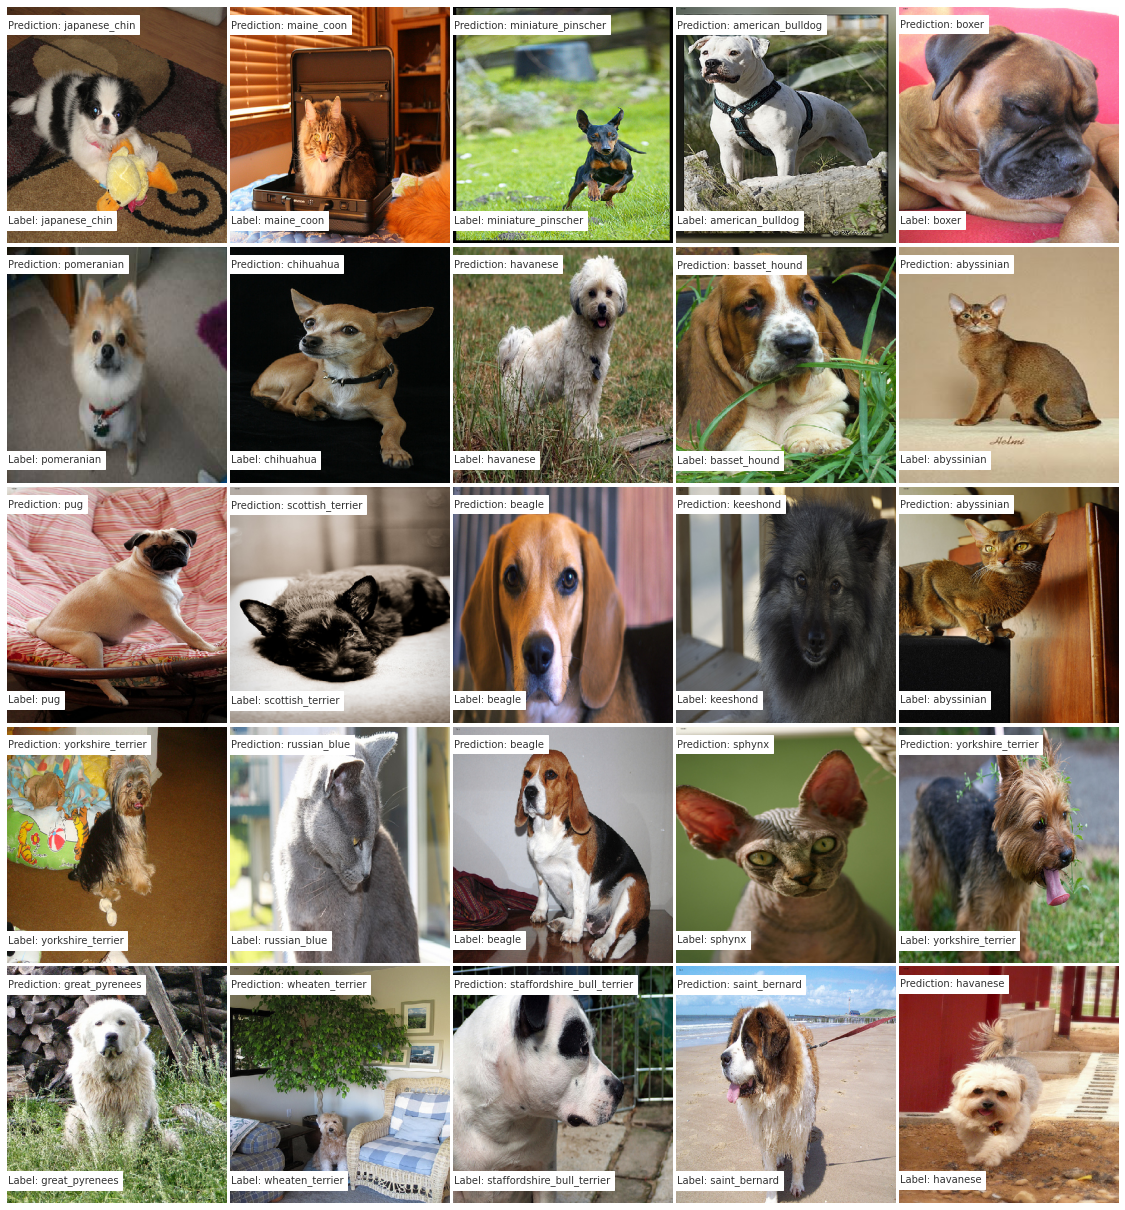

In [ ]:
np.random.seed(42)

fig = plt.figure(1, figsize=(25, 22))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.05)
for i, index in enumerate(np.random.choice(range(len(test_paths)), 25)):
  image = load_img(image_paths[index], target_size=(350, 325))
  label = breeds[index]

  ax = grid[i]
  ax.imshow(image)
  ax.text(0, 320, 'Label: {}'.format(label), color='k', backgroundcolor='w', alpha=0.8)

  predicted_label = get_ensemble_prediction(image_paths[index])

  ax.text(0, 30, 'Prediction: {}'.format(predicted_label), color='k', backgroundcolor='w', alpha=0.8)
  ax.axis(False)

plt.show()

After checking that my ensemble's performance was good, I retrained all the models in all the training, validation and testing splits, and **I used the same ensemble to participate in the Kaggle competition, achieving a multiclass loss of 0.27231, a better performance measure that the one achieved by the winner of the competition:**

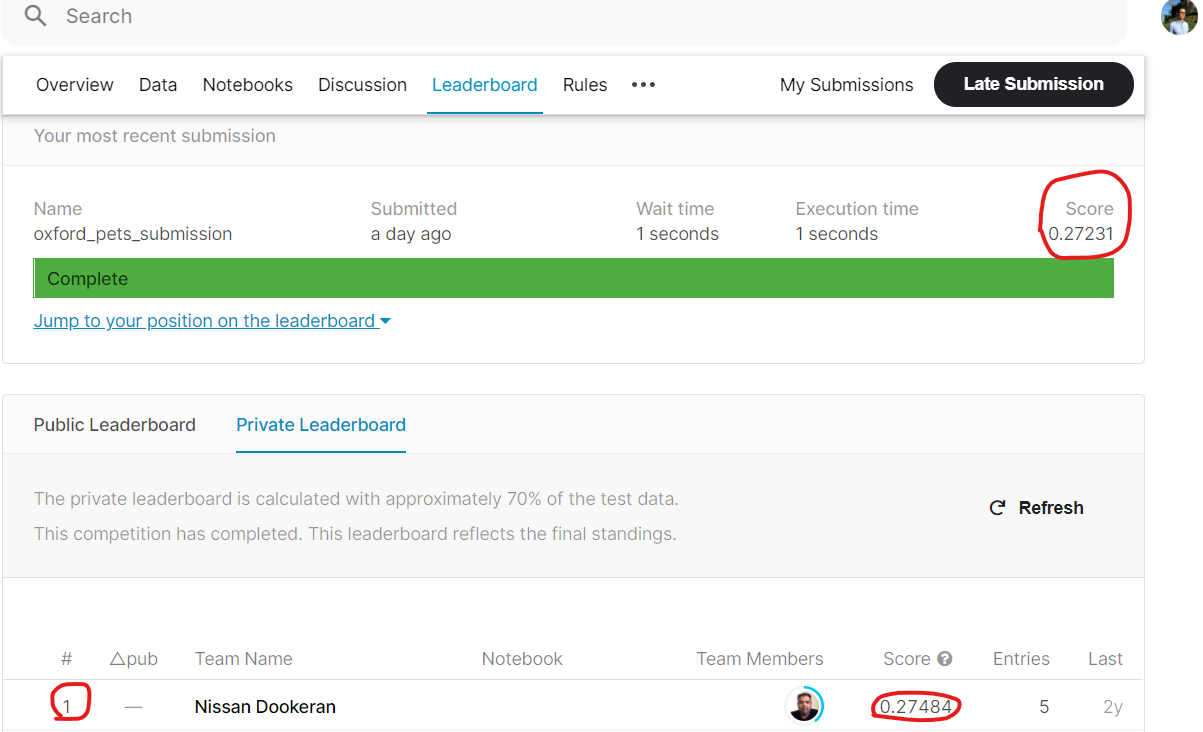

**With the performance metric being multiclass loss:**

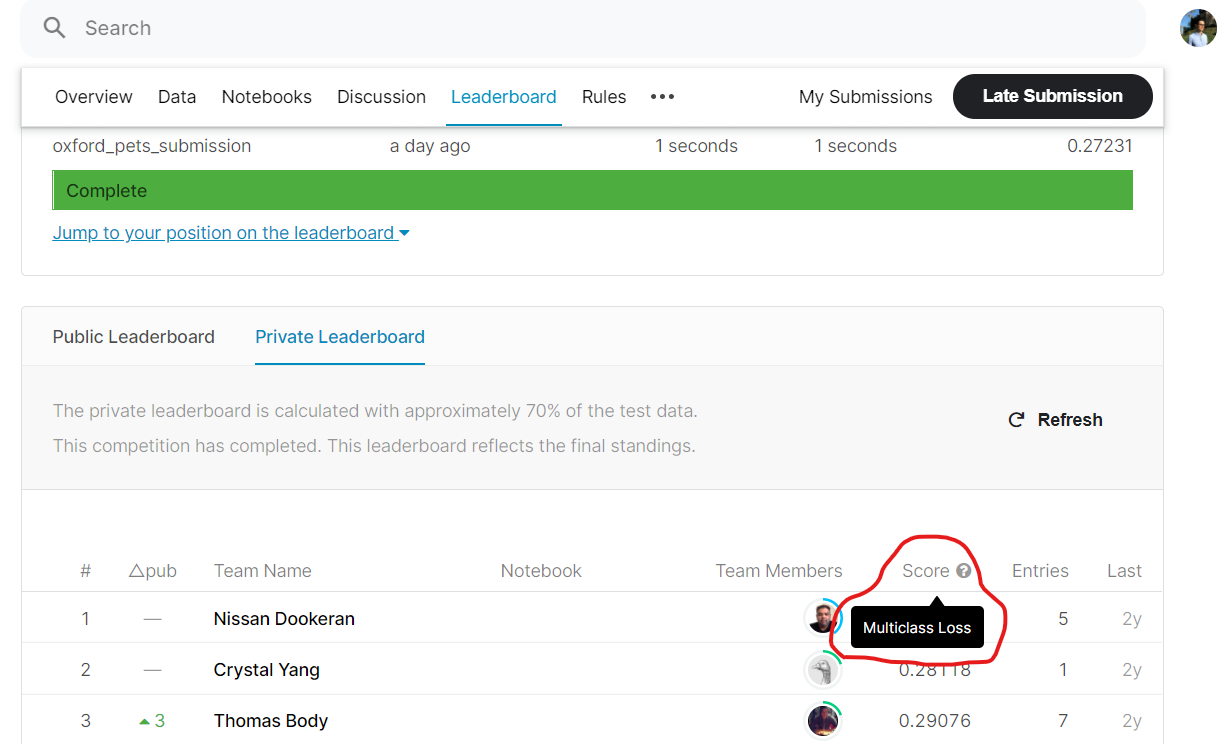